In [15]:
import pandas as pd
import gzip
import pickle
import os
import json

In [16]:
train_data = pd.read_csv("../files/input/train_data.csv.zip", index_col = False, compression = "zip")
test_data = pd.read_csv("../files/input/test_data.csv.zip", index_col = False, compression = "zip")

# Paso 1.
# Realice la limpieza de los datasets:
# - Renombre la columna "default payment next month" a "default".
# - Remueva la columna "ID".
# - Elimine los registros con informacion no disponible.
# - Para la columna EDUCATION, valores > 4 indican niveles superiores
#   de educación, agrupe estos valores en la categoría "others".
#
# Renombre la columna "default payment next month" a "default"
# y remueva la columna "ID".
#

In [17]:
train_data.rename(columns={"default payment next month": "default"}, inplace=True)
test_data.rename(columns={"default payment next month": "default"}, inplace=True)

train_data.drop(columns=["ID"], inplace=True)
test_data.drop(columns=["ID"], inplace=True)

train_data = train_data.loc[train_data['EDUCATION'] != 0]
test_data = test_data.loc[test_data['EDUCATION'] != 0]

train_data = train_data.loc[train_data['MARRIAGE'] != 0]
test_data = test_data.loc[test_data['MARRIAGE'] != 0]

train_data.loc[train_data['EDUCATION'] > 4, 'EDUCATION'] = 4
test_data.loc[test_data['EDUCATION'] > 4, 'EDUCATION'] = 4

print("Train data shape:", train_data.shape)

Train data shape: (20953, 24)


# Paso 2.
# Divida los datasets en x_train, y_train, x_test, y_test.

In [18]:
x_train = train_data.drop(columns=['default'])
y_train = train_data['default']

x_test = test_data.drop(columns=['default'])
y_test = test_data['default']

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (20953, 23)
y_train shape: (20953,)


# Paso 3.
# Cree un pipeline para el modelo de clasificación. Este pipeline debe
# contener las siguientes capas:
# - Transforma las variables categoricas usando el método
#   one-hot-encoding.
# - Escala las demas variables al intervalo [0, 1].
# - Selecciona las K mejores caracteristicas.
# - Ajusta un modelo de regresion logistica.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Identificar columnas categóricas y numéricas
categoricas = ['SEX', 'EDUCATION', 'MARRIAGE']
numericas = [col for col in x_train.columns if col not in categoricas]

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categoricas),
        ('num', MinMaxScaler(), numericas)
    ],
    remainder="passthrough"
)

#Selección de las k mejores características
k_best = SelectKBest(score_func=f_classif)

LR = LogisticRegression(42)

#Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', k_best), 
    ('classifier', LR)  
])
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE']),
                                                 ('num', MinMaxScaler(),
                                                  ['LIMIT_BAL', 'AGE', 'PAY_0',
                                                   'PAY_2', 'PAY_3', 'PAY_4',
                                                   'PAY_5', 'PAY_6',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score

param_grid = {
    'feature_selection__k': [1, 3, 5, 7, 10],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__max_iter': [100,200]
}

model=GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True
    )

model.fit(x_train, y_train)

print(f"Mejores parámetros: {model.best_params_}")
print(f"Precisión: {model.best_score_}")

Mejores parámetros: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'feature_selection__k': 1}
Precisión: 0.6392688664250823


c:\Analitica\Predictiva\Laboratorios\LAB-02-prediccion-del-default-usando-logreg-estgomezhen-svg-1\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
600 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Analitica\Predictiva\Laboratorios\LAB-02-prediccion-del-default-usando-logreg-estgomezhen-svg-1\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Analitica\Predictiva\Laboratorios\LAB-02-prediccion-del-default-usando-logreg-estgomezhen-svg-1\.venv\Lib\site-packages\sklearn\base.py

In [21]:
models_dir = '../files/models'
os.makedirs(models_dir, exist_ok=True)
output_path = "../files/models/model.pkl.gz"
with gzip.open(output_path, 'wb') as file:
    pickle.dump(model, file)

In [22]:
from sklearn.metrics import precision_score, balanced_accuracy_score, recall_score, f1_score

# Realizar las predicciones sobre los conjuntos de entrenamiento y prueba
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calcular métricas para el conjunto de entrenamiento
precision_train = precision_score(y_train, y_train_pred)
balanced_accuracy_train = balanced_accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

# Calcular métricas para el conjunto de prueba
precision_test = precision_score(y_test, y_test_pred)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Mostrar los resultados
print("Métricas para el conjunto de entrenamiento:")
print(f"Precisión: {precision_train:.4f}")
print(f"Precisión balanceada: {balanced_accuracy_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-score: {f1_train:.4f}")

print("\nMétricas para el conjunto de prueba:")
print(f"Precisión: {precision_test:.4f}")
print(f"Precisión balanceada: {balanced_accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-score: {f1_test:.4f}")

Métricas para el conjunto de entrenamiento:
Precisión: 0.6939
Precisión balanceada: 0.6393
Recall: 0.3196
F1-score: 0.4376

Métricas para el conjunto de prueba:
Precisión: 0.7018
Precisión balanceada: 0.6547
Recall: 0.3494
F1-score: 0.4665


In [23]:
# Guardar las métricas en un archivo json

import json

metrics = [
    {
        "type": "metrics",
        'dataset': 'train',
        'precision': precision_train,
        'balanced_accuracy': balanced_accuracy_train,
        'recall': recall_train,
        'f1_score': f1_train,
    },
    {
        "type": "metrics",
        'dataset': 'test',
        'precision': precision_test,
        'balanced_accuracy': balanced_accuracy_test,
        'recall': recall_test,
        'f1_score': f1_test,
    }
]

output_dir = "../files/output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir,"metrics.json")

with open(output_path,"w") as file:
        file.write(json.dumps(metrics) + '\n')

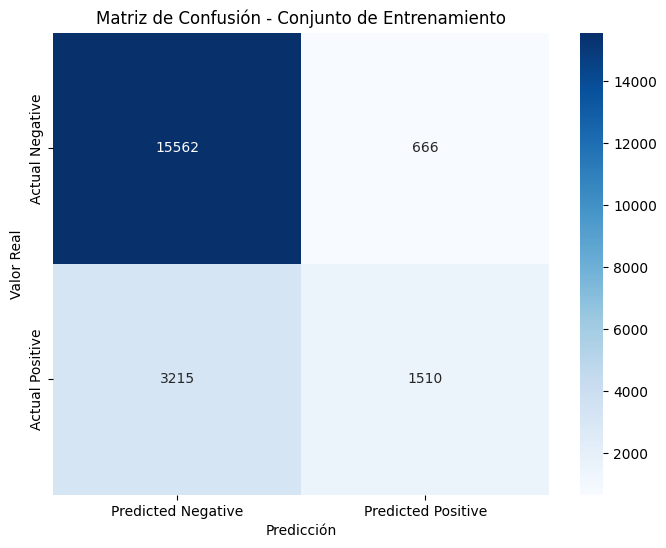

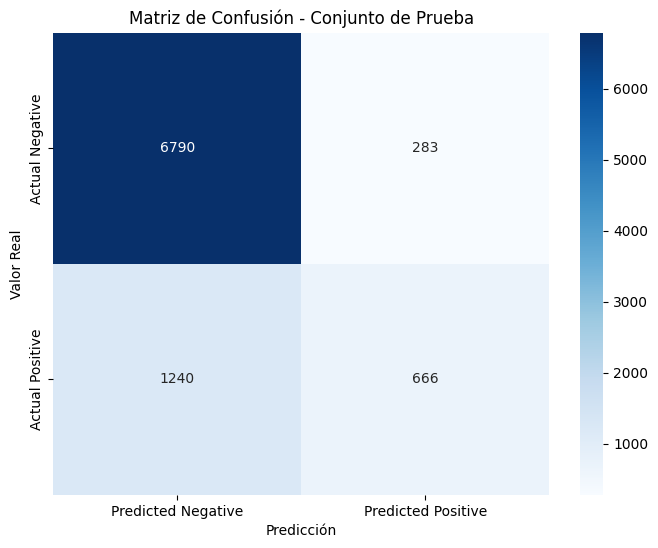

In [24]:
#Calcule las matrices de confusion para los conjuntos de entrenamiento y prueba.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión para el conjunto de entrenamiento
matriz_train = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_train, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Matriz de Confusión - Conjunto de Entrenamiento')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Matriz de confusión para el conjunto de prueba
matriz_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_test, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Matriz de Confusión - Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

In [25]:
# Guardar las matrices en un archivo json

matriz_metrics = [
    {
        'type': 'cm_matrix',
        'dataset': 'train',
        'true_0': {'predicted_0': int(matriz_train[0, 0]),'predicted_1': int(matriz_train[0, 1])},
        'true_1': {'predicted_0': int(matriz_train[1, 0]), 'predicted_1': int(matriz_train[1, 1])},
    },
    {
        'type': 'cm_matrix',
        'dataset': 'test',
        'true_0': {'predicted_0': int(matriz_test[0, 0]), 'predicted_1': int(matriz_test[0, 1])},
        'true_1': {'predicted_0': int(matriz_test[1, 0]), 'predicted_1': int(matriz_test[1, 1])},
    },
]

metrics.extend(matriz_metrics)

output_path = "../files/output/metrics.json"

with open(output_path, 'w', encoding="utf-8") as file:
    for obj in metrics:
        file.write(json.dumps(obj) + "\n")

In [26]:
with open("../files/output/metrics.json", "r") as file:
    contenido = file.read()
    print("Contenido del archivo JSON:")

Contenido del archivo JSON:
